In [129]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from IPython.display import clear_output

In [130]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Dataset'

In [131]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Dataset/')

In [133]:
df = pd.read_csv("tesseract.csv")

In [134]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [135]:
df.shape

(116, 30)

In [136]:
df.describe()

,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,PageWidth,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,77.896552,734.663793,774.413793,183.137931,26.172414,73.244131,913.594828,802.965517,2367.310345,1787.077586,...,0.114257,0.019891,0.032606,0.006202,0.024921,0.077284,0.024885,0.005784,0.005288,0.431034
std,45.198188,507.927895,583.415790,142.760298,10.860600,26.550087,516.614682,582.544761,419.772929,254.771719,...,0.162987,0.079340,0.135460,0.038796,0.082323,0.170594,0.082962,0.035994,0.028984,0.497369
min,0.000000,9.000000,44.000000,66.000000,13.000000,0.000000,107.000000,65.000000,319.000000,1653.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.750000,275.750000,353.750000,113.000000,20.000000,64.169218,429.500000,376.000000,2200.000000,1654.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,78.000000,654.500000,533.500000,134.000000,23.000000,82.692742,842.000000,572.500000,2339.000000,1670.000000,...,0.055845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,118.250000,1213.750000,1047.000000,178.000000,27.000000,92.788505,1391.750000,1082.750000,2339.000000,1700.000000,...,0.159477,0.000000,0.000000,0.000000,0.000000,0.033302,0.000000,0.000000,0.000000,1.000000
max,153.000000,2043.000000,2876.000000,1029.000000,76.000000,96.851837,2167.000000,2906.000000,3312.000000,2342.000000,...,0.854212,0.641643,0.863594,0.283237,0.666771,0.744913,0.757865,0.252860,0.201084,1.000000


In [137]:
len(df["imageName"].unique())

44

In [138]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        text = df["text"][index]
        date = list(datefinder.find_dates(text))[0]
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y<Y:
            df["isBottom"][index]=1
        elif y>Y:
            df["isTop"][index]=1
            
        
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth", "conf", "isPast", "isFuture"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [139]:
preProcess(df)

/tmp/ipykernel_11166/413941093.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_11166/413941093.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_11166/413941093.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_11166/413941093.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [140]:
df

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,0.275091,0.482257,0,1,0,1,0.541396,0.0,0.494869,0.0,0.151753,0.000000,0.000000,0.528837,0.0,0.0,0.0,0
1,0.927449,0.499786,0,1,1,0,0.111245,0.0,0.157799,0.0,0.804302,0.000000,0.000000,0.131721,0.0,0.0,0.0,1
2,0.591898,0.791364,1,0,1,0,0.120358,0.0,0.184538,0.0,0.000000,0.000000,0.162403,0.421051,0.0,0.0,0.0,0
3,0.591898,0.821719,1,0,1,0,0.116690,0.0,0.159205,0.0,0.000000,0.000000,0.132623,0.000000,0.0,0.0,0.0,0
4,0.906892,0.499786,0,1,1,0,0.090689,0.0,0.137243,0.0,0.783751,0.000000,0.000000,0.112152,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.878235,0.246818,0,1,1,0,0.000000,0.0,0.366004,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0
149,0.864706,0.198636,0,1,1,0,0.000000,0.0,0.347363,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
151,0.512402,0.177426,0,1,1,0,0.081065,0.0,0.124913,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1
152,0.878403,0.471997,0,1,1,0,0.031390,0.0,0.423249,0.0,0.283171,0.021537,0.042880,0.000000,0.0,0.0,0.0,0


In [141]:
df.describe()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,0.520881,0.346183,0.215517,0.784483,0.508621,0.491379,0.046758,0.003265,0.114257,0.019891,0.032606,0.006202,0.024921,0.077284,0.024885,0.005784,0.005288,0.431034
std,0.289285,0.261506,0.412965,0.412965,0.502095,0.502095,0.086447,0.015978,0.162987,0.079340,0.135460,0.038796,0.082323,0.170594,0.082962,0.035994,0.028984,0.497369
min,0.045766,0.019626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.251554,0.170909,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.503175,0.252140,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.055845,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.834341,0.472179,0.000000,1.000000,1.000000,1.000000,0.076240,0.000000,0.159477,0.000000,0.000000,0.000000,0.000000,0.033302,0.000000,0.000000,0.000000,1.000000
max,0.927449,1.865204,1.000000,1.000000,1.000000,1.000000,0.541396,0.098908,0.854212,0.641643,0.863594,0.283237,0.666771,0.744913,0.757865,0.252860,0.201084,1.000000


In [142]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
x,1.000000,-0.249552,-0.316487,0.316487,0.918012,-0.918012,-0.092284,0.175339,0.370592,0.112641,0.270715,-0.046468,0.210537,-0.063955,0.056344,0.013197,-0.180816,0.188118
y,-0.249552,1.000000,0.771581,-0.771581,-0.188993,0.188993,-0.029214,-0.167995,-0.154547,0.045142,0.064125,-0.066959,0.036578,0.209129,-0.096545,0.273197,-0.139800,-0.337793
isTop,-0.316487,0.771581,1.000000,-1.000000,-0.281633,0.281633,-0.074201,-0.107570,-0.190098,-0.077297,-0.126711,-0.084154,-0.083894,0.313734,-0.121546,0.053823,-0.096041,-0.329199
isBottom,0.316487,-0.771581,-1.000000,1.000000,0.281633,-0.281633,0.074201,0.107570,0.190098,0.077297,0.126711,0.084154,0.083894,-0.313734,0.121546,-0.053823,0.096041,0.329199
isRight,0.918012,-0.188993,-0.281633,0.281633,1.000000,-1.000000,-0.092965,0.201722,0.322514,0.079952,0.207053,-0.094126,0.203701,-0.046036,0.022399,0.044793,-0.186421,0.159095
isLeft,-0.918012,0.188993,0.281633,-0.281633,-1.000000,1.000000,0.092965,-0.201722,-0.322514,-0.079952,-0.207053,0.094126,-0.203701,0.046036,-0.022399,-0.044793,0.186421,-0.159095
date,-0.092284,-0.029214,-0.074201,0.074201,-0.092965,0.092965,1.000000,-0.111488,0.239139,0.018789,0.080132,0.278948,-0.016205,0.211698,0.039165,-0.051972,0.178980,0.016510
dated,0.175339,-0.167995,-0.107570,0.107570,0.201722,-0.201722,-0.111488,1.000000,0.289735,0.115312,0.005578,-0.032951,-0.020185,-0.093378,0.230125,-0.033124,-0.037605,0.059339
invoice,0.370592,-0.154547,-0.190098,0.190098,0.322514,-0.322514,0.239139,0.289735,1.000000,0.235105,0.042154,0.104036,-0.067746,0.201427,0.055767,-0.086774,-0.129007,0.021380
delivery,0.112641,0.045142,-0.077297,0.077297,0.079952,-0.079952,0.018789,0.115312,0.235105,1.000000,-0.036003,-0.040427,0.035213,0.040782,0.206830,0.107799,-0.046137,-0.048740


In [143]:
df.shape

(116, 18)

In [144]:
len(df[df["output"]==0])

66

In [145]:
len(df[df["output"]==1])

50

In [146]:
dfTrue = df[df["output"]==1].sample(frac=1)[:50]
dfFalse = df[df["output"]==0].sample(frac=1)[:50]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df


,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
90,0.383070,0.691657,1,0,0,1,0.000000,0.0,0.138155,0.0,0.000000,0.0,0.000000,0.200823,0.000000,0.000000,0.000000,0
136,0.704118,0.316818,0,1,1,0,0.000000,0.0,0.000000,0.0,0.167888,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0
85,0.331176,0.141818,0,1,0,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.164202,0.000000,0.000000,0.000000,1
86,0.852390,0.255884,0,1,1,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.181506,0.000000,1
145,0.226723,0.735672,1,0,0,1,0.000000,0.0,0.144327,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.408706,0.395896,0,1,0,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.148762,0.000000,0.000000,0.000000,0.000000,0
125,0.495163,0.529085,1,0,0,1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0
140,0.856471,0.161364,0,1,1,0,0.000000,0.0,0.073135,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1
21,0.707059,0.084545,0,1,1,0,0.063010,0.0,0.114637,0.0,0.180865,0.0,0.095453,0.000000,0.000000,0.000000,0.000000,1


In [147]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
x,1.000000,-0.287954,-0.350076,0.350076,0.914988,-0.914988,-0.073460,0.187238,0.366417,0.095292,0.284124,-0.054154,0.201828,-0.032832,0.067533,0.010953,-0.167226,0.198763
y,-0.287954,1.000000,0.762426,-0.762426,-0.229043,0.229043,-0.041009,-0.170919,-0.139252,0.062359,0.079652,-0.064966,0.023083,0.164845,-0.071344,0.296882,-0.107324,-0.346387
isTop,-0.350076,0.762426,1.000000,-1.000000,-0.321782,0.321782,-0.091086,-0.103913,-0.157324,-0.056498,-0.119547,-0.081186,-0.100473,0.272877,-0.094632,0.078276,-0.066698,-0.312348
isBottom,0.350076,-0.762426,-1.000000,1.000000,0.321782,-0.321782,0.091086,0.103913,0.157324,0.056498,0.119547,0.081186,0.100473,-0.272877,0.094632,-0.078276,0.066698,0.312348
isRight,0.914988,-0.229043,-0.321782,0.321782,1.000000,-1.000000,-0.089563,0.217396,0.316378,0.068777,0.217016,-0.102070,0.188931,-0.037354,0.038943,0.047866,-0.145235,0.180036
isLeft,-0.914988,0.229043,0.321782,-0.321782,-1.000000,1.000000,0.089563,-0.217396,-0.316378,-0.068777,-0.217016,0.102070,-0.188931,0.037354,-0.038943,-0.047866,0.145235,-0.180036
date,-0.073460,-0.041009,-0.091086,0.091086,-0.089563,0.089563,1.000000,-0.111769,0.278233,0.009894,0.096138,0.300615,-0.041984,0.195531,0.023704,-0.049955,0.067106,0.047944
dated,0.187238,-0.170919,-0.103913,0.103913,0.217396,-0.217396,-0.111769,1.000000,0.285603,0.113334,-0.000926,-0.038432,-0.023015,-0.094262,0.233577,-0.038635,-0.031574,0.032922
invoice,0.366417,-0.139252,-0.157324,0.157324,0.316378,-0.316378,0.278233,0.285603,1.000000,0.225224,0.029383,0.097105,-0.101637,0.232719,0.059826,-0.099057,-0.103514,-0.033279
delivery,0.095292,0.062359,-0.056498,0.056498,0.068777,-0.068777,0.009894,0.113334,0.225224,1.000000,-0.040259,-0.044607,0.006931,0.066220,0.217619,0.106458,-0.036647,-0.072512


In [148]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [149]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [150]:
xTrain.shape

(80, 17)

In [151]:
xTest.shape

(20, 17)

In [152]:
yTrain.shape

(80,)

In [153]:
yTest.shape

(20,)

In [154]:
def getModel():
    model = keras.Sequential([
    keras.layers.Dense(32,  input_shape=(17, ), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])
    
    return model



In [155]:
model = getModel()

In [156]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 32)                576       
                                                                 
 dense_46 (Dense)            (None, 32)                1056      
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [157]:
history = model.fit(xTrain, yTrain, epochs=300, batch_size=2)

Epoch 1/300
40/40 [==============================] - 1s 1ms/step - loss: 0.6982 - accuracy: 0.4875 - precision: 0.4750 - recall: 0.4872 - true_positives: 19.0000 - true_negatives: 20.0000 - false_positives: 21.0000 - false_negatives: 20.0000 
Epoch 2/300
40/40 [==============================] - 0s 1ms/step - loss: 0.6909 - accuracy: 0.5250 - precision: 0.5152 - recall: 0.4359 - true_positives: 17.0000 - true_negatives: 25.0000 - false_positives: 16.0000 - false_negatives: 22.0000
Epoch 3/300
40/40 [==============================] - 0s 1ms/step - loss: 0.6825 - accuracy: 0.5500 - precision: 0.5366 - recall: 0.5641 - true_positives: 22.0000 - true_negatives: 22.0000 - false_positives: 19.0000 - false_negatives: 17.0000
Epoch 4/300
40/40 [==============================] - 0s 2ms/step - loss: 0.6781 - accuracy: 0.6000 - precision: 0.5714 - recall: 0.7179 - true_positives: 28.0000 - true_negatives: 20.0000 - false_positives: 21.0000 - false_negatives: 11.0000
Epoch 5/300
40/40 [============

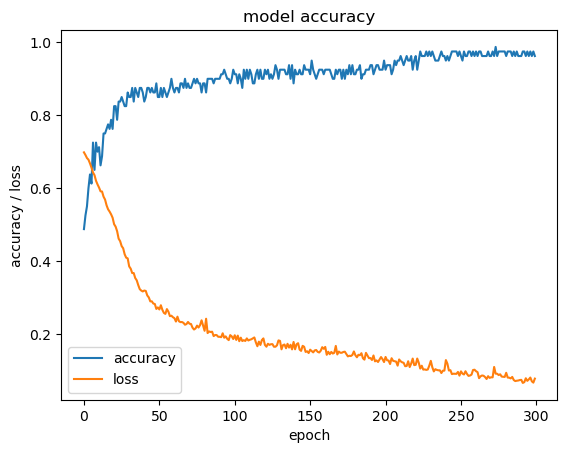

In [158]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [159]:
model.evaluate(xTest, yTest)

1/1 [==============================] - 0s 272ms/step - loss: 0.9515 - accuracy: 0.8000 - precision: 0.7692 - recall: 0.9091 - true_positives: 10.0000 - true_negatives: 6.0000 - false_positives: 3.0000 - false_negatives: 1.0000


[0.9514707326889038,
 0.800000011920929,
 0.7692307829856873,
 0.9090909361839294,
 10.0,
 6.0,
 3.0,
 1.0]

In [161]:
from sklearn.model_selection import KFold

In [164]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [165]:
i=0
scores = []
for train_index, test_index in list(KFold(n_splits=3).split(X,Y)):
    i+=1
    print("Fold ", str(i))
    x_train,x_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=Y.iloc[train_index],Y.iloc[test_index]
   
    model=getModel()

    model.fit(x_train, y_train,epochs=300, batch_size=1, verbose=2)
    clear_output(wait=True)

    results = model.evaluate(x_test, y_test)

    scores.append(results)

2/2 [==============================] - 0s 6ms/step - loss: 1.9821 - accuracy: 0.7879 - precision: 0.7647 - recall: 0.8125 - true_positives: 13.0000 - true_negatives: 13.0000 - false_positives: 4.0000 - false_negatives: 3.0000


In [166]:
acc = [score[1] for score in scores]
print("Accuracy : ", acc)
print("Mean Accuracy : ", sum(acc)/len(acc))

Accuracy :  [0.6764705777168274, 0.8181818127632141, 0.7878788113594055]
Mean Accuracy :  0.7608437339464823


In [90]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel/Models/')

In [91]:
model.save("InvoiceDate.h5")